# MNIST: TensorFlow CNN

In this tutorial we will adapt the
[MNIST example](https://github.com/malmaud/TensorFlow.jl/blob/master/examples/mnist_full.jl)
from [TensorFlow.jl](https://github.com/malmaud/TensorFlow.jl)
to utilize a custom augmentation pipeline.
In order to showcase the effect that image augmentation can
have on a neural network's ability to generalize, we will
limit the training set to just the first 500 images (of the
available 60,000!). For more information on the dataset see
[MNIST1998].


## Preparing the MNIST dataset

In order to access, prepare, and visualize the MNIST images we
employ the help of three additional Julia packages. In the
interest of time and space we will not go into great detail
about their functionality. Feel free to click on their
respective names to find out more information about the
utility they can provide.

- [MLDatasets.jl](https://github.com/JuliaML/MLDatasets.jl)
  has an MNIST submodule that offers a convenience interface
  to read the MNIST database.

- [Images.jl](https://github.com/JuliaImages/Images.jl) will
  provide us with the necessary tools to process and display
  the image data in Julia / Juypter.

- [MLDataUtils.jl](https://github.com/JuliaML/MLDataUtils.jl)
  implements a variety of functions to convert and partition
  Machine Learning datasets. This will help us prepare the
  MNIST data to be used with TensorFlow.

In [1]:
using Images, MLDatasets, MLDataUtils
srand(42);

As you may have seen previously in the
[elastic distortions tutorial](@ref elastic), the function
`MNIST.traintensor` returns the MNIST training images
corresponding to the given indices as a multi-dimensional
array. These images are stored in the native horizontal-major
memory layout as a single array of `Float64`. All the
individual values are scaled to be between `0.0` and `1.0`.
Also note, how the observations are laid out along the last
array dimension

In [2]:
@show summary(MNIST.traintensor(1:500));

summary(MNIST.traintensor(1:500)) = "28×28×500 Array{Float64,3}"


The corresponding label of each image is stored as an integer
value between `0` and `9`. That means that if the label has
the value `3`, then the corresponding image is known to be a
handwritten "3". To show a more concrete example, the
following code reveals that the first training image denotes a
"5" and the second training image a "0" (etc).

In [3]:
@show summary(MNIST.trainlabels(1:500))
println("First eight labels: ", join(MNIST.trainlabels(1:8),", "))

summary(MNIST.trainlabels(1:500)) = "500-element Array{Int64,1}"
First eight labels: 5, 0, 4, 1, 9, 2, 1, 3


For TensorFlow we will require a slightly different dimension
layout for the images. More specifically, we will move the
observations into the first array dimension. The labels will
be transformed into a one-of-k matrix. For performance reasons,
we will further convert all the numerical values to be of type
`Float32`. We will do all this by creating a little utility
function that we will name `prepare_mnist`.

In [4]:
"""
    prepare_mnist(tensor, labels) -> (X, Y)

Change the dimension layout x1×x2×N of the given array
`tensor` to N×x1×x2 and store the result in `X`.
The given vector `labels` is transformed into a 10×N
one-hot matrix `Y`. Both, `X` and `Y`, will have the
element type `Float32`.
"""
function prepare_mnist(tensor, labels)
    features = convert(Array{Float32}, permutedims(tensor, (3,1,2)))
    targets = convertlabel(LabelEnc.OneOfK{Float32}, labels, 0:9, ObsDim.First())
    features, targets
end

prepare_mnist

With `prepare_mnist` defined, we can now use it in conjunction
with the functions in the `MLDatasets.MNIST` sub-module to load
and prepare our training set. Recall that for this tutorial only
use the first 500 images of the training set will be used.

summary(train_x) = "500×28×28 Array{Float32,3}"
summary(train_y) = "500×10 Array{Float32,2}"


,,,,,,,

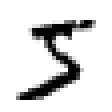
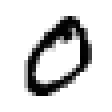
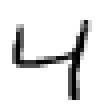
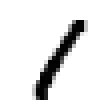
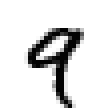
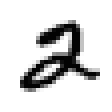
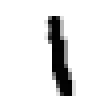
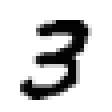

In [5]:
train_x, train_y = prepare_mnist(MNIST.traintensor(1:500), MNIST.trainlabels(1:500))
@show summary(train_x) summary(train_y);
[MNIST.convert2image(train_x[i,:,:]) for i in 1:8]

Similarly, we use `MNIST.testtensor` and `MNIST.testlabels`
to load the full MNIST test set. We will utilize that data to
measure how well the network is able to generalize with and
without augmentation.

summary(test_x) = "10000×28×28 Array{Float32,3}"
summary(test_y) = "10000×10 Array{Float32,2}"


,,,,,,,

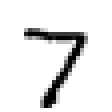
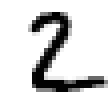
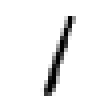
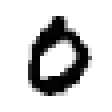
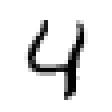
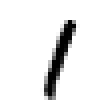
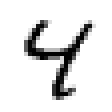
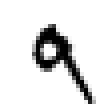

In [6]:
test_x, test_y = prepare_mnist(MNIST.testtensor(), MNIST.testlabels())
@show summary(test_x) summary(test_y);
[MNIST.convert2image(test_x[i,:,:]) for i in 1:8]

## Defining the Network

With the dataset prepared, we can now instantiate our neural
network. To keep things simple, we will use the same
convolutional network as defined in the
[MNIST example](https://github.com/malmaud/TensorFlow.jl/blob/master/examples/mnist_full.jl)
of Julia's TensorFlow package.

In [7]:
using TensorFlow, Distributions
session = Session(Graph());

2017-09-29 02:28:54.313988: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-29 02:28:54.314009: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-29 02:28:54.314013: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-09-29 02:28:54.314028: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-29 02:28:54.314031: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [8]:
function weight_variable(shape...)
    initial = map(Float32, rand(Normal(0, .001), shape...))
    return Variable(initial)
end

function bias_variable(shape...)
    initial = fill(Float32(.1), shape...)
    return Variable(initial)
end

function conv2d(x, W)
    nn.conv2d(x, W, [1, 1, 1, 1], "SAME")
end

function max_pool_2x2(x)
    nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
end

max_pool_2x2 (generic function with 1 method)

In [9]:
@tf begin
    x = placeholder(Float32)
    y = placeholder(Float32)

    W_conv1 = weight_variable(5, 5, 1, 32)
    b_conv1 = bias_variable(32)

    x_image = reshape(x, [-1, 28, 28, 1])

    h_conv1 = nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable(5, 5, 32, 64)
    b_conv2 = bias_variable(64)

    h_conv2 = nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable(7*7*64, 1024)
    b_fc1 = bias_variable(1024)

    h_pool2_flat = reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = nn.relu(h_pool2_flat * W_fc1 + b_fc1)

    keep_prob = placeholder(Float32)
    h_fc1_drop = nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable(1024, 10)
    b_fc2 = bias_variable(10)

    y_conv = nn.softmax(h_fc1_drop * W_fc2 + b_fc2)

    global cross_entropy = reduce_mean(-reduce_sum(y.*log(y_conv+1e-8), axis=[2]))
    global optimizer = train.minimize(train.AdamOptimizer(1e-4), cross_entropy)

    correct_prediction = broadcast(==, indmax(y_conv, 2), indmax(y, 2))
    global accuracy = reduce_mean(cast(correct_prediction, Float32))
end

<Tensor accuracy:1 shape=unknown dtype=Float32>

## Training without Augmentation

In order to get an intuition for how useful augmentation can
be, we need a sensible baseline to compare to. To that end, we
will first train the network we just defined using only the
(unaltered) 500 training examples.

The package
[ValueHistories.jl](https://github.com/JuliaML/ValueHistories.jl)
will help us record the accuracy during the training process.
We will use those logs later to visualize the differences
between having augmentation or no augmentation.

In [10]:
using ValueHistories

To keep things simple, we will not overly optimize our
training function. Thus, we will be content with using a
closure. Because both, the baseline and the augmented version,
will share this "inefficiency", we should still get a decent
enough picture of their performance differences.

In [11]:
function train_baseline(; epochs=500, batchsize=100, reset=true)
    reset && run(session, global_variables_initializer())
    log = MVHistory()
    for epoch in 1:epochs
        for (batch_x, batch_y) in eachbatch(shuffleobs((train_x, train_y), obsdim=1), size=batchsize, obsdim=1)
            run(session, optimizer, Dict(x=>batch_x, y=>batch_y, keep_prob=>0.5))
        end

        if (epoch % 50) == 0
            train = run(session, accuracy, Dict(x=>train_x, y=>train_y, keep_prob=>1.0))
            test  = run(session, accuracy, Dict(x=>test_x,  y=>test_y,  keep_prob=>1.0))
            @trace log epoch train test
            msg = "epoch " * lpad(epoch,4) * ": train accuracy " * rpad(round(train,3),5,"0") * ", test accuracy " * rpad(round(test,3),5,"0")
            println(msg)
        end
    end
    log
end

train_baseline (generic function with 1 method)

Aside from the accuracy, we will also keep an eye on the
training time. In particular we would like to see if and how
the addition of augmentation causes our training time to
increase.

In [12]:
train_baseline(epochs=1) # warm-up
baseline_log = @time train_baseline(epochs=1000);

epoch   50: train accuracy 0.658, test accuracy 0.570
epoch  100: train accuracy 0.846, test accuracy 0.749
epoch  150: train accuracy 0.878, test accuracy 0.781
epoch  200: train accuracy 0.906, test accuracy 0.807
epoch  250: train accuracy 0.930, test accuracy 0.819
epoch  300: train accuracy 0.950, test accuracy 0.824
epoch  350: train accuracy 0.962, test accuracy 0.829
epoch  400: train accuracy 0.980, test accuracy 0.835
epoch  450: train accuracy 0.992, test accuracy 0.834
epoch  500: train accuracy 0.994, test accuracy 0.832
epoch  550: train accuracy 0.998, test accuracy 0.835
epoch  600: train accuracy 1.000, test accuracy 0.836
epoch  650: train accuracy 1.000, test accuracy 0.836
epoch  700: train accuracy 1.000, test accuracy 0.838
epoch  750: train accuracy 1.000, test accuracy 0.836
epoch  800: train accuracy 1.000, test accuracy 0.843
epoch  850: train accuracy 1.000, test accuracy 0.834
epoch  900: train accuracy 1.000, test accuracy 0.839
epoch  950: train accuracy 1

As we can see, the accuracy on the training set is around a
100%, while the accuracy on the test set peaks around 85%. For
a mere 500 training examples, this isn't actually that bad of
a result.

## Integrating Augmentor

Now that we have a network architecture with a baseline to
compare to, let us finally see what it takes to add Augmentor
to our experiment. First, we need to include the package to
our experiment.

In [13]:
using Augmentor

The next step, and maybe the most human-hour consuming part of
adding image augmentation to a prediction problem, is to
design and select a sensible augmentation pipeline. Take a
look at the [elastic distortions tutorial](@ref elastic) for
an example of how to do just that.

For this example, we already choose a quite complicated but
promising augmentation pipeline for you. This pipeline was
designed to yield a large variation of effects as well as to
showcase how even deep pipelines are quite efficient in terms
of performance.

In [14]:
pl = PermuteDims(2,1) |>
     ShearX(-5:5) * ShearY(-5:5) |>
     Rotate(-15:15) |>
     CropSize(28,28) |>
     Zoom(0.9:0.1:1.2) |>
     CacheImage() |>
     ElasticDistortion(10) |>
     PermuteDims(2,1)

8-step Augmentor.ImmutablePipeline:
 1.) Permute dimension order to (2, 1)
 2.) Either: (50%) ShearX by ϕ ∈ -5:5 degree. (50%) ShearY by ψ ∈ -5:5 degree.
 3.) Rotate by θ ∈ -15:15 degree
 4.) Crop a 28×28 window around the center
 5.) Zoom by I ∈ {0.9×0.9, 1.0×1.0, 1.1×1.1, 1.2×1.2}
 6.) Cache into temporary buffer
 7.) Distort using a smoothed and normalized 10×10 grid with pinned border
 8.) Permute dimension order to (2, 1)

Most of the used operations are quite self explanatory, but
there are some details about this pipeline worth pointing out
explicitly.

1. We use the operation [`PermuteDims`](@ref) to convert the
   horizontal-major MNIST image to a julia-native
   vertical-major image. The vertical-major image is then
   processed and converted back to a horizontal-major array.
   We mainly do this here to showcase the option, but it is
   also to keep consistent with how the data is usually used
   in the literature. Alternatively, one could just work with
   the MNIST data in a vertical-major format all the way
   through without any issue.

2. As counter-intuitive as it sounds, the operation
   [`CacheImage`](@ref) right before
   [`ElasticDistortion`](@ref) is actually used to improve
   performance. If we were to omit it, then the whole pipeline
   would be applied in one single pass. In this case, applying
   distortions on top of affine transformations lazily is in
   fact less efficient than using a temporary variable.

With the pipeline now defined, let us quickly peek at what
kind of effects we can achieve with it. In particular, lets
apply the pipeline multiple times to the first training image
and look at what kind of results it produces.

,,,,,,,
,,,,,,,

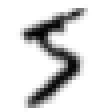
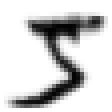
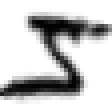
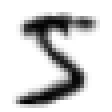
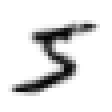
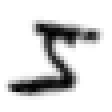
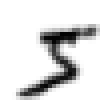
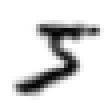
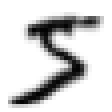
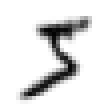
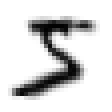
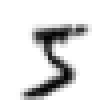
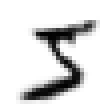
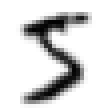
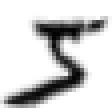
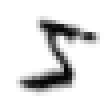

In [15]:
[MNIST.convert2image(augment(train_x[1,:,:], pl)) for i in 1:8, j in 1:2]

As we can see, we can achieve a wide range of effects, from
more subtle to more pronounced. The important part is that all
examples are still clearly representative of the true label.

Next, we have to adapt the function `train_baseline` to make
use of our augmentation pipeline. To integrate Augmentor
efficiently, there are three necessary changes we have to
make.

1. Preallocate a buffer with the same size and element type
   that each batch has.

   ```
   augmented_x = zeros(Float32, batchsize, 28, 28)
   ```

2. Add a call to [`augmentbatch!`](@ref) in the inner loop of
   the batch iterator using our pipeline and buffer.

   ```
   augmentbatch!(augmented_x, batch_x, pl, ObsDim.First())
   ```

3. Replace `x=>batch_x` with `x=>augmented_x` in the call to
   TensorFlow's `run(session, ...)`.

Applying these changes to our `train_baseline` function
will give us something similar to the following function.
Note how all the other parts of the function remain exactly
the same as before.

In [16]:
function train_augmented(; epochs=500, batchsize=100, reset=true)
    reset && run(session, global_variables_initializer())
    log = MVHistory()
    augm_x = zeros(Float32, batchsize, size(train_x,2), size(train_x,3))
    for epoch in 1:epochs
        for (batch_x, batch_y) in eachbatch(shuffleobs((train_x, train_y), obsdim=1), size=batchsize, obsdim=1)
            augmentbatch!(CPUThreads(), augm_x, batch_x, pl, ObsDim.First())
            run(session, optimizer, Dict(x=>augm_x, y=>batch_y, keep_prob=>0.5))
        end

        if (epoch % 50) == 0
            train = run(session, accuracy, Dict(x=>train_x, y=>train_y, keep_prob=>1.0))
            test  = run(session, accuracy, Dict(x=>test_x,  y=>test_y,  keep_prob=>1.0))
            @trace log epoch train test
            msg = "epoch " * lpad(epoch,4) * ": train accuracy " * rpad(round(train,3),5,"0") * ", test accuracy " * rpad(round(test,3),5,"0")
            println(msg)
        end
    end
    log
end

train_augmented (generic function with 1 method)

You may have noticed in the code above that we also pass a
`CPUThreads()` as the first argument to [`augmentbatch!`](@ref).
This instructs Augmentor to process the images of the batch in
parallel using multi-threading. For this to work properly you
will need to set the environment variable `JULIA_NUM_THREADS`
to the number of threads you wish to use. You can check how
many threads are used with the function `Threads.nthreads()`

In [17]:
@show Threads.nthreads();

Threads.nthreads() = 12


Now that all pieces are in place, let us train our network
once more. We will use the same parameters except that now
instead of the original training images we will be using
randomly augmented images. This will cause every epoch to be
different.

In [18]:
train_augmented(epochs=1) # warm-up
augmented_log = @time train_augmented(epochs=1000);

epoch   50: train accuracy 0.650, test accuracy 0.574
epoch  100: train accuracy 0.812, test accuracy 0.729
epoch  150: train accuracy 0.852, test accuracy 0.772
epoch  200: train accuracy 0.868, test accuracy 0.794
epoch  250: train accuracy 0.878, test accuracy 0.814
epoch  300: train accuracy 0.898, test accuracy 0.828
epoch  350: train accuracy 0.922, test accuracy 0.833
epoch  400: train accuracy 0.932, test accuracy 0.844
epoch  450: train accuracy 0.934, test accuracy 0.853
epoch  500: train accuracy 0.940, test accuracy 0.852
epoch  550: train accuracy 0.946, test accuracy 0.864
epoch  600: train accuracy 0.954, test accuracy 0.874
epoch  650: train accuracy 0.960, test accuracy 0.872
epoch  700: train accuracy 0.962, test accuracy 0.872
epoch  750: train accuracy 0.974, test accuracy 0.884
epoch  800: train accuracy 0.978, test accuracy 0.894
epoch  850: train accuracy 0.984, test accuracy 0.896
epoch  900: train accuracy 0.978, test accuracy 0.902
epoch  950: train accuracy 0

As we can see, our network reaches far better results on our
testset than our baseline network did. However, we can also
see that the training took quite a bit longer than before.
This difference generally decreases as the complexity of the
utilized neural network increases. Yet another way to improve
performance (aside from simplifying the augmentation pipeline)
would be to increase the number of available threads.

## Visualizing the Results

Before we end this tutorial, let us make use the
[Plots.jl](https://github.com/JuliaPlots/Plots.jl) package to
visualize and discuss the recorded training curves.
We will plot the accuracy curves of both networks side by side
in order to get a good feeling about their differences.

In [19]:
using Plots
pyplot()

Plots.PyPlotBackend()


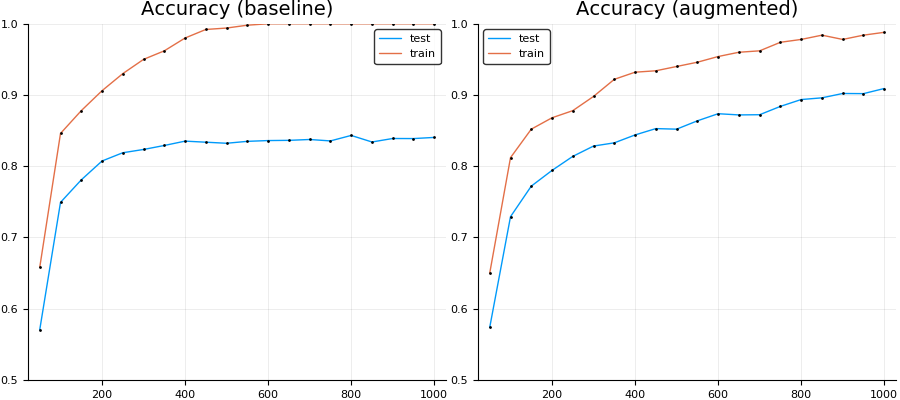

In [22]:
plt = plot(
    plot(baseline_log,  title="Accuracy (baseline)",  ylim=(.5,1)),
    plot(augmented_log, title="Accuracy (augmented)", ylim=(.5,1)),
    size = (900, 400),
    markersize = 1
)
plt

Note how the accuracy on the (unaltered) training set
increases much faster for the baseline network than for the
augmented one. This is to be expected, since our augmented
network doesn't actually use the unaltered images for
training, and thus has not actually seen them. Given this
information, it is worth pointing out explicitly how the
accuracy on training set is still greater than on the test set
for the augmented network as well. This is also not a
surprise, given that the augmented images are likely more
similar to their original ones than to the test images.

For the baseline network, the accuracy on the test set
plateaus quite quickly (around 85%). For the augmented network
on the other hand, it the accuracy keeps increasing for quite
a while longer. If you let the network train long enough you
can achieve around 97% even before it stops learning.

## References

**MNIST1998**: LeCun, Yan, Corinna Cortes, Christopher J.C. Burges. ["The MNIST database of handwritten digits"](http://yann.lecun.com/exdb/mnist/) Website. 1998.